In [84]:
!pip install transformers

In [85]:
# from google.colab import drive
# drive.mount('/content/drive')

In [86]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

```python 
    def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    This function rescale the image's pixel intensity range. 
    e.g. original  
    [[ 34,  89, 200],
    [123, 178, 255],
    [ 12,  45, 100]]
    after rescaling : 
    [[0.133, 0.349, 0.784],
    [0.482, 0.698, 1.000],
    [0.047, 0.176, 0.392]]
```
why use it for the first step :
1. Smoother gradients: Using values ​​of [0, 1] helps prevent exploding or vanishing gradients, thus improving the training stability of the model.
2. Faster convergence: When the input data range is smaller, the neural network can converge faster, that is, find the optimal solution faster, and the training efficiency is higher.

In [87]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

Shape: torch.Size([3, 223, 320]), Dtype: torch.float32
Shape: torch.Size([3, 375, 500]), Dtype: torch.float32


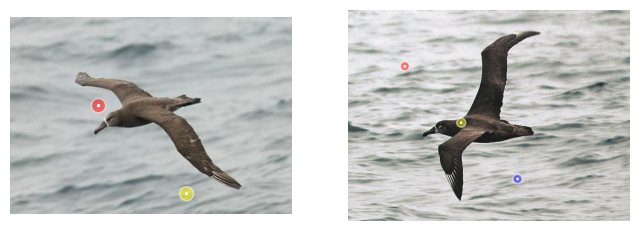

In [88]:
# This is the test code for above two functions : draw_correspondences and imsc
# It should display two images with points marked on them.
from PIL import Image
import matplotlib.pyplot as plt

image1 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg')
image2 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg')

# check the file path
# image1.show()
# image2.show()

image1_tensor = pil_to_tensor(image1).float()  # convert to tensor
image2_tensor = pil_to_tensor(image2).float()

print(f"Shape: {image1_tensor.shape}, Dtype: {image1_tensor.dtype}")
print(f"Shape: {image2_tensor.shape}, Dtype: {image2_tensor.dtype}")

points1 = [(100, 100), (200, 200), (300, 300)]
points2 = [(100, 100), (200, 200), (300, 300)]


fig = draw_correspondences(points1, points2, image1_tensor, image2_tensor)

plt.show()


In [89]:
#@title create dataset


from transformers import AutoProcessor


# CLIP Model for image, pre-processing
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r') as f:
    parts = [line.strip() for line in f.readlines()]


class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


variable x: tensor([[[ 0.8792,  0.7771,  0.8355,  ..., -0.0842, -0.0842,  0.0763],
         [ 0.8938,  0.8063,  0.8501,  ..., -0.1718, -0.0842, -0.0405],
         [ 0.7771,  0.8209,  0.9376,  ..., -0.2302, -0.0988, -0.2010],
         ...,
         [ 0.2515,  0.3829,  0.2223,  ..., -0.4638, -0.2886, -0.1572],
         [ 0.2661,  0.3245,  0.3537,  ..., -0.4784, -0.4930, -0.5806],
         [ 0.2515,  0.3537,  0.2953,  ..., -0.5952, -0.5222, -0.4638]],

        [[ 2.0149,  2.0299,  2.0449,  ...,  0.4691,  0.6491,  0.7242],
         [ 2.0299,  2.0299,  2.0149,  ...,  0.4390,  0.5291,  0.6942],
         [ 2.0449,  2.0449,  2.0149,  ...,  0.4390,  0.4841,  0.5441],
         ...,
         [ 0.7392,  0.6491,  0.6191,  ...,  0.4240,  0.5891,  0.8442],
         [ 0.7392,  0.7692,  0.6792,  ...,  0.3490,  0.3340,  0.4691],
         [ 0.7692,  0.7542,  0.7692,  ...,  0.3340,  0.3490,  0.3490]],

        [[ 0.8661,  0.9514,  0.9088,  ..., -0.2146, -0.0582,  0.0982],
         [ 0.8377,  0.8945,  0.93

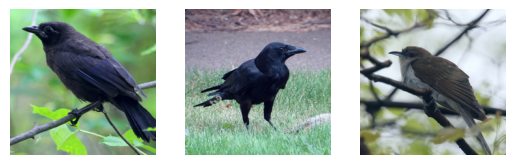

In [90]:
#@title dataset and dataloader and load samples

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/' # You need to change this.
base_path = '../data/CUB_200_2011/' # You need to change this.

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

random.seed(30)
inputs, labels = [], []
data_indices = []
#data_indices = random.sample(range(train_dataset.__len__()), 10)
# Here is where we pick the images to analyse. It is smart to pick one image from the same class and one from a different class.
# That generally gives more interesting results. The data is ordered, so class 1 starts from indices (0-30), class 2 from (30-60)
# and so on.

data_indices.append(856)
data_indices.append(858)
data_indices.append(924)


for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)
  print(f"variable x: {x}")
  print(f"variable y: {y}")

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)

print(labels)

plt.figure(1)
plt.subplot(131)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(132)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(133)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.show()


In [91]:
#@title load model

from transformers import CLIPVisionModel, CLIPTextModel

# You can use the CLIPTextModel to process the text data once you get that far.
# see https://huggingface.co/docs/transformers/model_doc/clip#transformers.TFCLIPTextModel
# for more information.

model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')

text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')


inpus: [tensor([[[ 0.8792,  0.7771,  0.8355,  ..., -0.0842, -0.0842,  0.0763],
         [ 0.8938,  0.8063,  0.8501,  ..., -0.1718, -0.0842, -0.0405],
         [ 0.7771,  0.8209,  0.9376,  ..., -0.2302, -0.0988, -0.2010],
         ...,
         [ 0.2515,  0.3829,  0.2223,  ..., -0.4638, -0.2886, -0.1572],
         [ 0.2661,  0.3245,  0.3537,  ..., -0.4784, -0.4930, -0.5806],
         [ 0.2515,  0.3537,  0.2953,  ..., -0.5952, -0.5222, -0.4638]],

        [[ 2.0149,  2.0299,  2.0449,  ...,  0.4691,  0.6491,  0.7242],
         [ 2.0299,  2.0299,  2.0149,  ...,  0.4390,  0.5291,  0.6942],
         [ 2.0449,  2.0449,  2.0149,  ...,  0.4390,  0.4841,  0.5441],
         ...,
         [ 0.7392,  0.6491,  0.6191,  ...,  0.4240,  0.5891,  0.8442],
         [ 0.7392,  0.7692,  0.6792,  ...,  0.3490,  0.3340,  0.4691],
         [ 0.7692,  0.7542,  0.7692,  ...,  0.3340,  0.3490,  0.3490]],

        [[ 0.8661,  0.9514,  0.9088,  ..., -0.2146, -0.0582,  0.0982],
         [ 0.8377,  0.8945,  0.9372, 

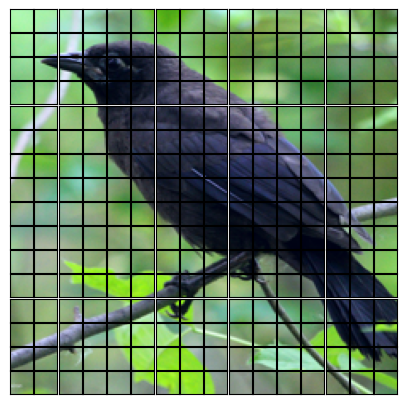

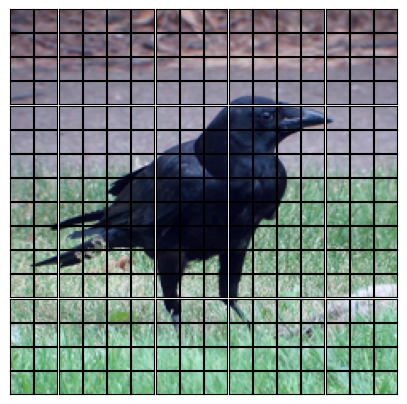

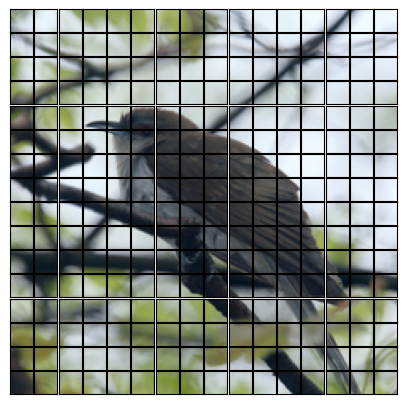

In [92]:
#@title plot patches

print(f"inpus: {inputs}")
for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    # original permute(0,1,2) -> (C,H,W)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape
    # new shape (H, W, C)
    print(f"img shape: {img.shape}")

    # create a random tensor with the same shape as the input image, batch size 1
    dummy_input = torch.zeros(1, C, H, W, device='cuda')

    outputs = model(dummy_input)
    print(f"outputs: {outputs}")

    # 256 patches, 1024 features
    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    # patch_width = 14
    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width
    # n_rows = 16, n_cols = 16

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]
    print(f"cropped_img shape: {cropped_img.shape}")
    

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    # create pathes 
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)



input shape: torch.Size([1, 3, 224, 224])
embedding shape: (256, 1024)
input shape: torch.Size([1, 3, 224, 224])
embedding shape: (256, 1024)
input shape: torch.Size([1, 3, 224, 224])
embedding shape: (256, 1024)
last_hidden_state: torch.Size([15, 6, 512])
pooled_output: torch.Size([15, 512])
Similarity matrix shape: torch.Size([256, 512])
Similarity matrix shape: torch.Size([256, 512])
Similarity matrix shape: torch.Size([256, 512])
Image 0: Matched labels for patches
  Patch 0: 4 breast
  Patch 1: 4 breast
  Patch 2: 4 breast
  Patch 3: 4 breast
  Patch 4: 4 breast
  Patch 5: 4 breast
  Patch 6: 4 breast
  Patch 7: 4 breast
  Patch 8: 1 back
  Patch 9: 4 breast
  Patch 10: 4 breast
  Patch 11: 4 breast
  Patch 12: 4 breast
  Patch 13: 4 breast
  Patch 14: 4 breast
  Patch 15: 4 breast
  Patch 16: 4 breast
  Patch 17: 1 back
  Patch 18: 1 back
  Patch 19: 4 breast
  Patch 20: 4 breast
  Patch 21: 4 breast
  Patch 22: 1 back
  Patch 23: 4 breast
  Patch 24: 4 breast
  Patch 25: 1 back


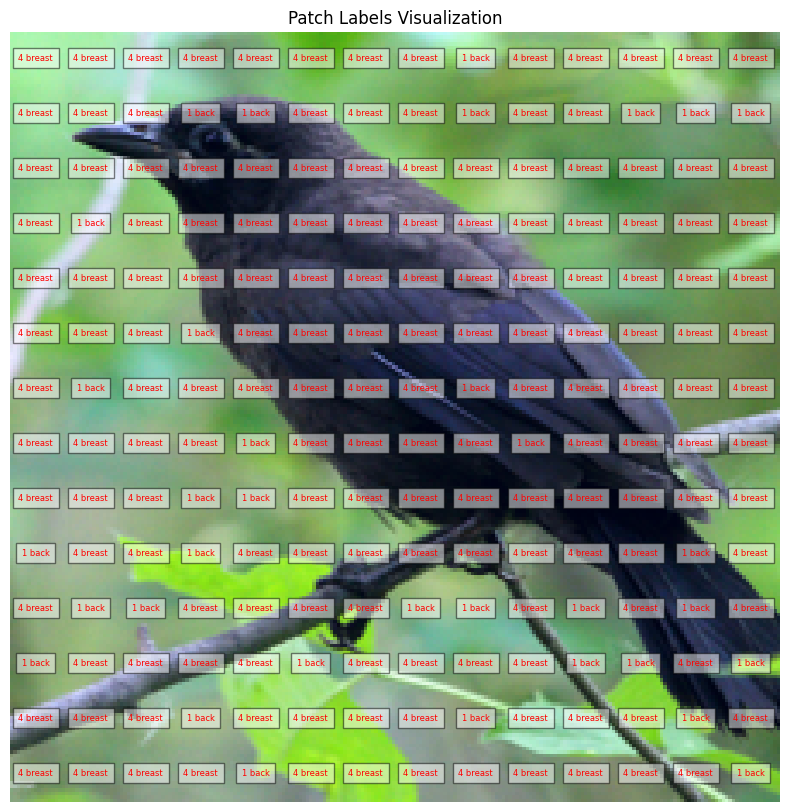

Start visualizing image 1


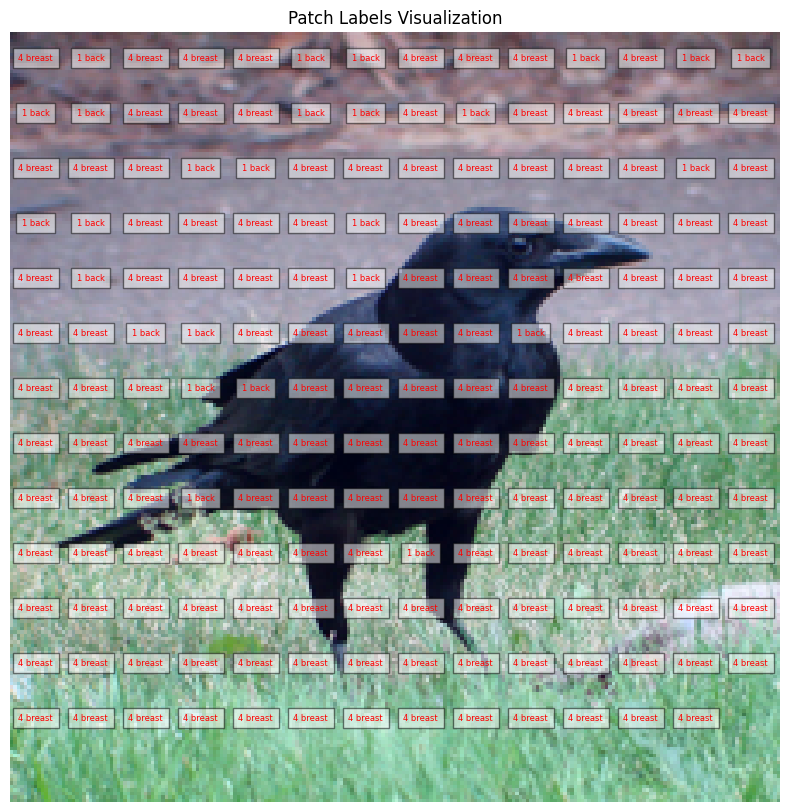

Start visualizing image 2


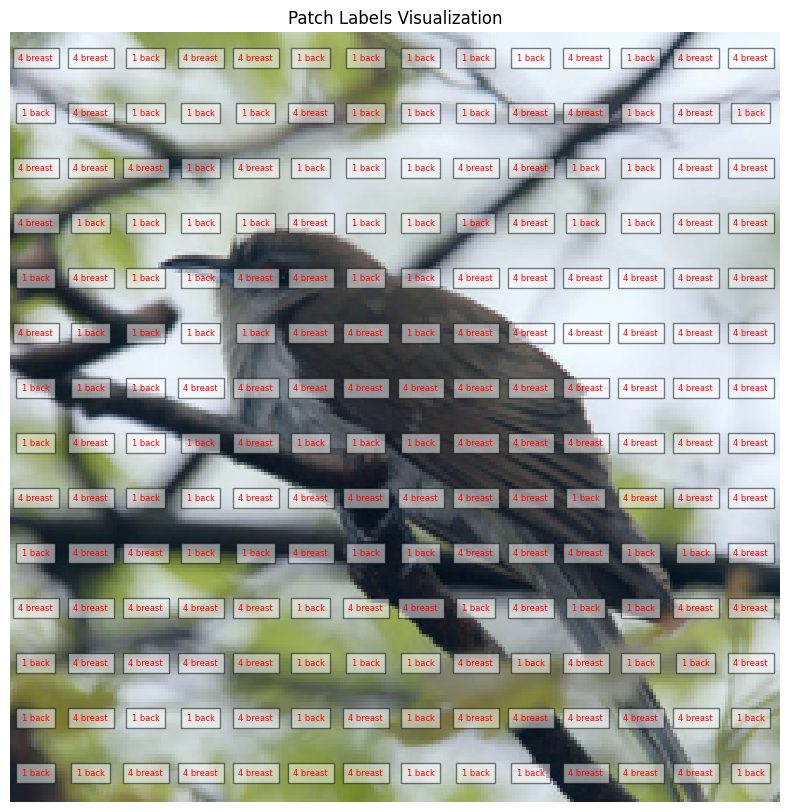

In [125]:
#@title create patch embeddings

device='cuda'

embedings = []

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)
        print(f"input shape:", input_i.shape)
        # vision model with input image
        outputs = model(input_i, output_attentions=True)
        # last_hidden_state: (batch_size, sequence_length, hidden_size)
        embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))
        
        print(f"embedding shape:",embedings[counter].shape)

# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r') as f:
    parts = [line.strip() for line in f.readlines()]

from transformers import AutoTokenizer, CLIPTextModel
from torch.nn.functional import cosine_similarity

new_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

text_inputs = tokenizer(parts, padding=True, return_tensors="pt")
new_outputs = new_model(**text_inputs)
new_last_hidden_state = new_outputs.last_hidden_state
new_pooled_output = new_outputs.pooler_output  # pooled (EOS token) states
print("last_hidden_state:", new_last_hidden_state.shape)
print("pooled_output:", new_pooled_output.shape)

device = 'cuda'
projection_layer = torch.nn.Linear(1024, 512).to(device)
# Convert text embeddings to tensor
parts_embeddings = new_pooled_output.to(device)  # Shape: (num_parts, 512)

# Process each image's patch embeddings
matched_labels = []
for img_idx, patch_embedding in enumerate(embedings):
    patch_embedding = torch.tensor(patch_embedding, device=device)  # Shape: (num_patches, 1024)
    projected_patch_embedding = projection_layer(patch_embedding)  # Shape: (num_patches, 512)
    
    # Calculate cosine similarity between each patch and each part
    similarity_matrix = cosine_similarity(
        projected_patch_embedding.unsqueeze(1),  # Shape: (num_patches, 1, 512)
        parts_embeddings.unsqueeze(0)           # Shape: (1, num_parts, 512)
    )
    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    
    # Find the part with the highest similarity for each patch
    best_match_indices = similarity_matrix.argmax(dim=1)  # Shape: (num_patches,)
    # print(f"Best match indices: {best_match_indices.cpu().numpy()}")

    # Ensure indices are within range
    valid_indices = [idx for idx in best_match_indices.cpu().numpy() if idx < len(parts)]
    matched_labels.append([parts[idx] for idx in valid_indices])
    
# Print or analyze matched labels
for img_idx, labels in enumerate(matched_labels):
    print(f"Image {img_idx}: Matched labels for patches")
    for patch_idx, label in enumerate(labels):
        print(f"  Patch {patch_idx}: {label}")

# visualize the patches and their corresponding parts 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def normalize_image(image):
    """
    Normalize an image tensor to the range [0, 1].
    
    Args:
    - image (torch.Tensor or np.ndarray): Input image.

    Returns:
    - Normalized image.
    """
    return (image - image.min()) / (image.max() - image.min())

def visualize_patches_with_labels(image, matched_labels, patch_size=16, stride=16):
    """
    Visualize the patches of the image with their corresponding labels.
    
    Args:
    - image (torch.Tensor): Input image tensor of shape (C, H, W).
    - matched_labels (list): List of labels for each patch.
    - patch_size (int): Size of each patch (default: 16).
    - stride (int): Stride used for extracting patches (default: 16).
    """
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) for visualization
    image = normalize_image(image)  # Normalize pixel values to [0, 1]
    H, W, _ = image.shape
    n_rows = (H - patch_size) // stride + 1
    n_cols = (W - patch_size) // stride + 1

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")

    # Overlay labels on each patch
    for i in range(n_rows):
        for j in range(n_cols):
            patch_idx = i * n_cols + j
            if patch_idx < len(matched_labels):
                label = matched_labels[patch_idx]
                y = i * stride + patch_size // 2
                x = j * stride + patch_size // 2
                plt.text(x, y, label, color="red", fontsize=6, ha="center", va="center", bbox=dict(facecolor="white", alpha=0.5))
    
    plt.title("Patch Labels Visualization")
    plt.show()

# Visualize the image and its labels
for img_idx, (img, labels) in enumerate(zip(inputs, matched_labels)):
    print(f"Start visualizing image {img_idx}")
    visualize_patches_with_labels(img, labels, patch_size=model.config.patch_size)



In [94]:
#@title STEP 1: find best buddies

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=0, metric='cosine')

best_buddies = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(NUMBER_OF_PATCHES)

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]

print(best_buddies_query_indices)



[  1   4   6   7   8  13  14  17  19  21  27  28  29  30  33  34  36  41
  42  45  48  49  51  57  58  61  77  78  87  91  94  95 102 103 110 112
 119 126 127 131 133 138 139 140 147 149 153 156 157 160 165 166 172 174
 177 182 192 196 202 211 217 231 238 242 244 248]


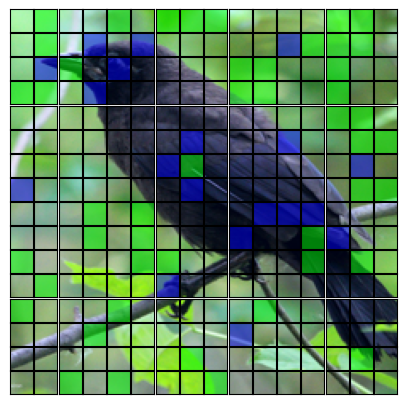

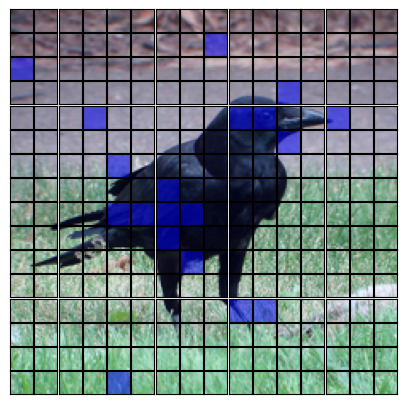

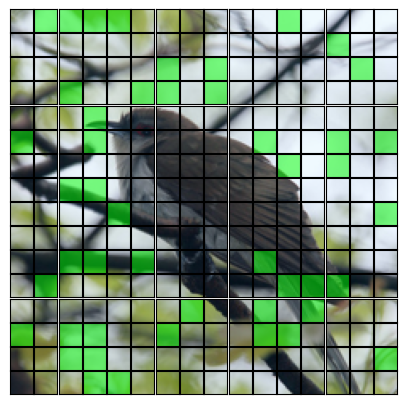

In [95]:
#@title plot patches with best buddies


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [96]:
#@title STEP 2: find foreground and remove best buddies beloning to background

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
# The following variable is important for the thresholding. You either set it to 0 or 1.
# In the more complete code this happens automatically as you will see later.
pca_component_to_threshold = 1
pca_features = pca.fit_transform(np.concatenate(embedings))

threshold = np.mean(pca_features[:, pca_component_to_threshold])
foreground_mask = pca_features[:, pca_component_to_threshold] > threshold+0.5*np.std(pca_features[:, pca_component_to_threshold])
foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)

prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

print(sum(best_buddies))

best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])
best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

print(sum(best_buddies))

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]


66
13


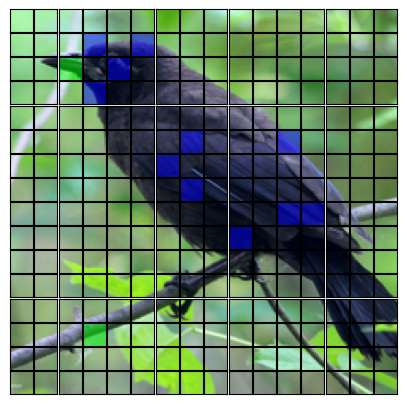

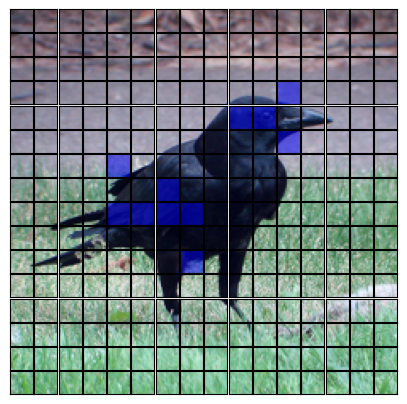

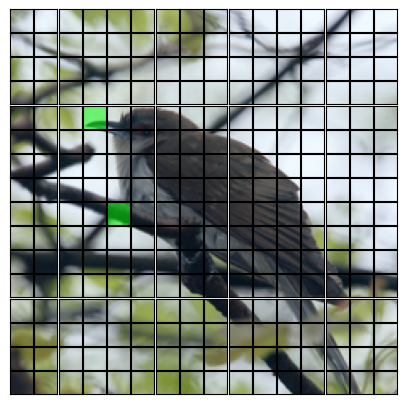

In [97]:
#@title plot patches with best buddies and background masked out


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [98]:
#@title STEP 3: cluster best buddies


NUMBER_OF_PAIRS = 5 # This determines the number of clusters

bb_query = embedings[0][best_buddies, :]
bb_prototypes = np.concatenate(embedings[1:])[nearest_neighbor_query[best_buddies], :]

bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=NUMBER_OF_PAIRS, random_state=0, n_init=10).fit(bb_combined_patches)
indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
query_indices_to_show = np.arange(NUMBER_OF_PATCHES)[indices_to_show]
prototype_indices_to_show = nearest_neighbor_query[indices_to_show]


print(query_indices_to_show)
print(prototype_indices_to_show)


[211  19 140  34  36]
[388  59 132 323  74]


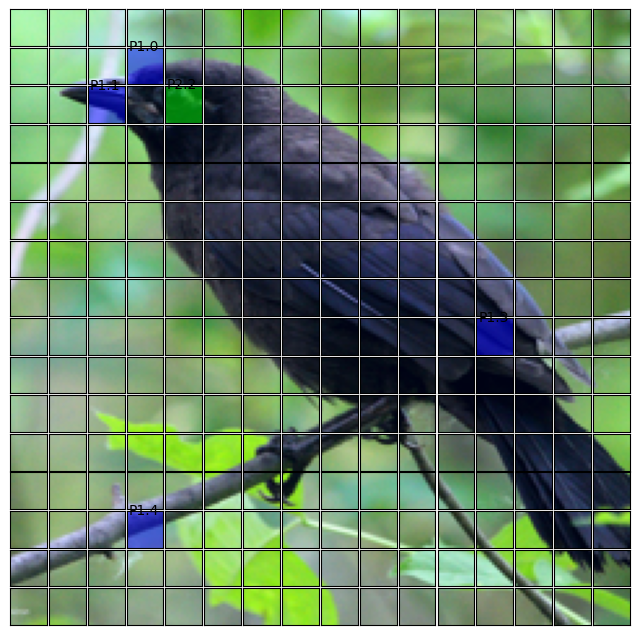

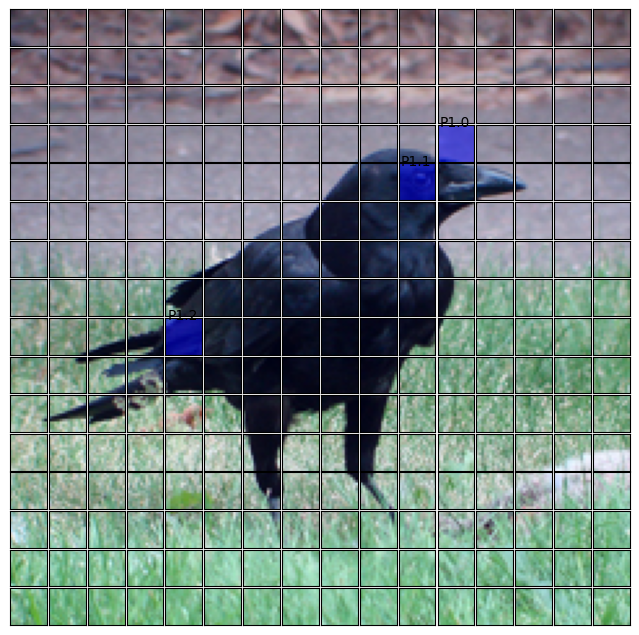

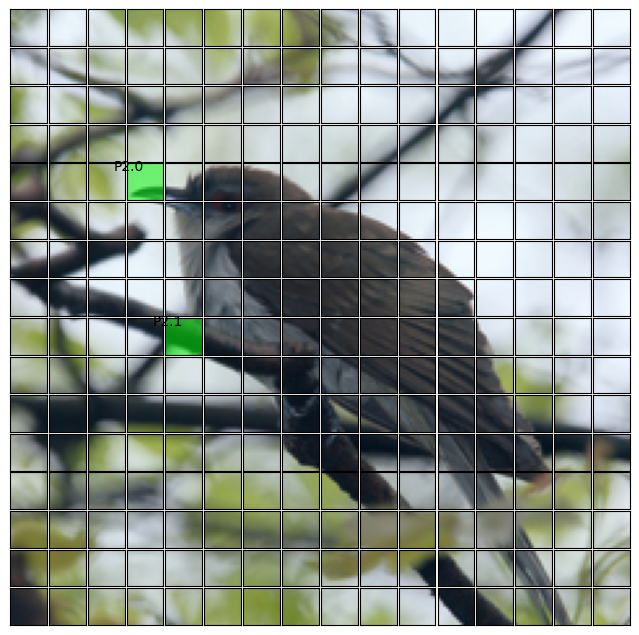

In [99]:
#@title plot query and prototypes with keypoints

for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in query_indices_to_show:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.0, 0.0, f"P2.{best_buddy_counter}")
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.4, 0.5, f"P1.{best_buddy_counter}")

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.3, 0.0, f"P1.{best_buddy_counter}")
                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.5, 0.5, f"P2.{best_buddy_counter}", horizontalalignment='center', verticalalignment='center')
                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)


